In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

2023-06-23 10:51:56.154073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
local_zip = 'fft_npa.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/data')
zip_ref.close()

In [3]:
VALIDATION_DIR = '/data/fft_npa/val'
TEST_DIR = '/data/fft_npa/test'
TRAINING_DIR = '/data/fft_npa/train'

In [4]:
# Load FFT features from numpy arrays
def load_data(directory):
    mfcc_features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            if not os.path.isfile(file_path):
                continue
            mfcc = np.load(file_path)
            mfcc_features.append(mfcc)
            labels.append(label)
    return mfcc_features, labels

In [5]:
# Load training data
train_mfcc_features, train_labels = load_data(TRAINING_DIR)

# Load validation data
val_mfcc_features, val_labels = load_data(VALIDATION_DIR)

# Load test data
test_mfcc_features, test_labels = load_data(TEST_DIR)

In [6]:
# Convert labels to numeric values
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

In [7]:
# Convert the data to NumPy arrays
X_train = np.array(train_mfcc_features)
y_train = np.array(encoded_train_labels)

X_val = np.array(val_mfcc_features)
y_val = np.array(encoded_val_labels)

X_test = np.array(test_mfcc_features)
y_test = np.array(encoded_test_labels)

In [8]:
# Reshape the input data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Determine the shape of the FFT features
input_shape = X_train.shape[1:]

In [9]:
# Define the model architecture
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(256, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])
    return model

In [10]:
# Create the model
model = create_model(input_shape=input_shape)
early_stop_training = EarlyStopping(monitor = 'val_accuracy', patience=10,restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00009),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2023-06-23 10:53:09.802239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22250 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:81:00.0, compute capability: 8.6


In [11]:
stop_training_callback = early_stop_training
history = model.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), callbacks=[stop_training_callback])

2023-06-23 10:53:24.855165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2469600000 exceeds 10% of free system memory.
2023-06-23 10:53:28.129880: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2469600000 exceeds 10% of free system memory.


Epoch 1/120


2023-06-23 10:53:32.563037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-23 10:53:34.047014: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-23 10:53:34.056770: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fa69eb8cc90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-23 10:53:34.056798: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-06-23 10:53:34.077405: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-23 10:53:34.330305: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

438/438 [==============================] - 61s 123ms/step - loss: 0.4869 - accuracy: 0.7657 - val_loss: 0.4120 - val_accuracy: 0.8310
Epoch 2/120
438/438 [==============================] - 29s 66ms/step - loss: 0.3574 - accuracy: 0.8491 - val_loss: 0.3591 - val_accuracy: 0.8605
Epoch 3/120
438/438 [==============================] - 28s 63ms/step - loss: 0.2982 - accuracy: 0.8749 - val_loss: 0.3114 - val_accuracy: 0.8685
Epoch 4/120
438/438 [==============================] - 28s 63ms/step - loss: 0.2478 - accuracy: 0.8982 - val_loss: 0.2754 - val_accuracy: 0.8900
Epoch 5/120
438/438 [==============================] - 28s 64ms/step - loss: 0.2205 - accuracy: 0.9086 - val_loss: 0.2577 - val_accuracy: 0.9090
Epoch 6/120
438/438 [==============================] - 27s 63ms/step - loss: 0.1791 - accuracy: 0.9262 - val_loss: 0.2250 - val_accuracy: 0.9105
Epoch 7/120
438/438 [==============================] - 27s 62ms/step - loss: 0.1463 - accuracy: 0.9429 - val_loss: 0.2118 - val_accuracy: 0.9

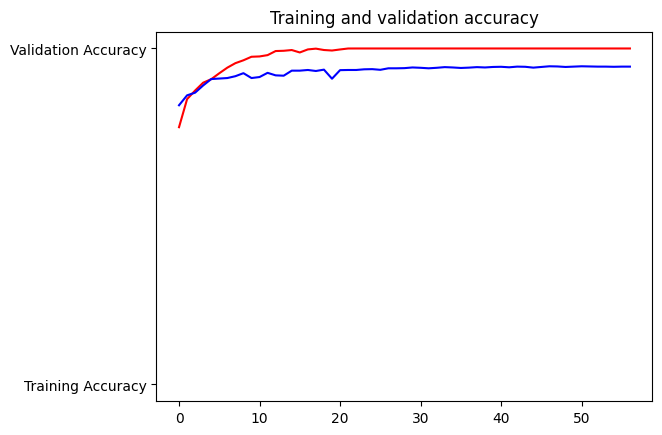

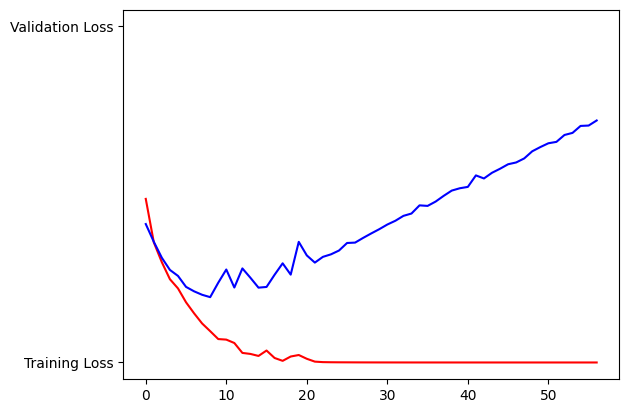

In [12]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix, classification_report
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = np.argmax(model.predict(X_test), axis=-1)

y_test_labels = label_encoder.inverse_transform(encoded_test_labels)
y_pred_labels = label_encoder.inverse_transform(y_pred)

cm = confusion_matrix(y_test_labels, y_pred_labels)

classification_rep = classification_report(y_test_labels, y_pred_labels)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_rep)

125/125 [==============================] - 2s 14ms/step - loss: 0.5196 - accuracy: 0.9517
Test Loss: 0.5196482539176941
Test Accuracy: 0.9517499804496765
125/125 [==============================] - 2s 11ms/step
Confusion Matrix:
[[1925   75]
 [ 116 1884]]

Classification Report:
               precision    recall  f1-score   support

    Queen_FFT       0.94      0.96      0.95      2000
Queenless_FFT       0.96      0.94      0.95      2000

     accuracy                           0.95      4000
    macro avg       0.95      0.95      0.95      4000
 weighted avg       0.95      0.95      0.95      4000



In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 44098, 32)         128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22049, 32)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22047, 64)         6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11023, 64)        0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 11021, 128)        24704     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 5510, 128)        0

In [20]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

NameError: name 'keras' is not defined